In [1]:
import pandas as pd
import scipy
from scipy.stats import poisson
from scipy.stats import multinomial
from scipy.stats import norm
import warnings

import glob
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

In [3]:
path = "/home/felipe/JoaoPino/1-LQsCollider_project/Data_MadGraph/Full_data"

all_Signal = glob.glob(path + "/Correct_weights/LQ_Tchannel_1p5TeV.csv")
all_ttbar = glob.glob(path + "/ttbar_*.csv")
all_WW = glob.glob(path + "/WW_*.csv")
all_ZZ = glob.glob(path + "/ZZ_*.csv")
all_ZW = glob.glob(path + "/ZW_*.csv")
all_Zplusjets = glob.glob(path + "/Z_plus_jets_*.csv")


In [4]:
li_Signal = []
li_ttbar = []
li_WW = []
li_ZZ = []
li_ZW = []
li_Zplusjets = []

#Signal
for filename in all_Signal:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_Signal.append(df)

Signal = pd.concat(li_Signal, axis=0, ignore_index=True)

#ttbar
for filename in all_ttbar:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_ttbar.append(df)

ttbar = pd.concat(li_ttbar, axis=0, ignore_index=True)

#WW
for filename in all_WW:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_WW.append(df)

WW = pd.concat(li_WW, axis=0, ignore_index=True)

#ZZ
for filename in all_ZZ:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_ZZ.append(df)

ZZ = pd.concat(li_ZZ, axis=0, ignore_index=True)

#ZW
for filename in all_ZW:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_ZW.append(df)

ZW = pd.concat(li_ZW, axis=0, ignore_index=True)

#Z plus jets
for filename in all_Zplusjets:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_Zplusjets.append(df)

Z_plus_jets = pd.concat(li_Zplusjets, axis=0, ignore_index=True)

Diboson = pd.concat([WW, ZZ, ZW],axis=0)

In [5]:
#Reweight backgrounds to higher-order cross sections

#Cross sections: Sums all values in collumn 'weight' in each data frame
#Divided by the number of samples. I have batches of 10 samples, each with 100K events

#ttbar
ttbar_N3LO = 988.57
ttbar_LO = 93.32
ttbar_new_weight = (ttbar['xs_weight']*ttbar_N3LO)/ttbar_LO
xsec_N3LO_ttbar = (ttbar_new_weight.sum()*1000)/10

#Z plus jets
Zjets_NNLO = 6.33*1e4
Zjets_LO = 4128.0
Zjets_new_weight = (Z_plus_jets['xs_weight']*Zjets_NNLO)/Zjets_LO
xsec_NNLO_Zjets = (Zjets_new_weight.sum()*1000)/10

#VV +jets. Cross sections for each individual process 
#WW + jets
WW_NLO = 124.31
WW_LO = 77.22
WW_new_weight = (WW['xs_weight']*WW_NLO)/WW_LO
xsec_NNLO_WW = (WW_new_weight.sum()*1000)/10

#WZ + jets
ZW_NLO = 51.82
ZW_LO = 0.9827
ZW_new_weight = (ZW['xs_weight']*ZW_NLO)/ZW_LO
xsec_NNLO_ZW = (ZW_new_weight.sum()*1000)/10

#ZZ + jets
ZZ_NLO = 17.72
ZZ_LO = 0.03654
ZZ_new_weight = (ZZ['xs_weight']*ZZ_NLO)/ZZ_LO
xsec_NNLO_ZZ = (ZZ_new_weight.sum()*1000)/10


In [6]:
ttbar['xs_weight'] = ttbar_new_weight
Z_plus_jets['xs_weight'] = Zjets_new_weight
WW['xs_weight'] = WW_new_weight
ZW['xs_weight'] = ZW_new_weight
ZZ['xs_weight'] = ZZ_new_weight

Diboson = pd.concat([WW, ZZ, ZW],axis=0)

In [7]:
print("Available observables : \n\n {}".format(np.transpose(list(Diboson))))

Available observables : 

 ['pt_l1' 'pt_l2' 'E_l1' 'E_l2' 'eta_l1' 'eta_l2' 'phi_l1' 'phi_l2'
 'DeltaR_l1l2' 'DeltaPhi_l1l2' 'DeltaTheta_l1l2' 'DeltaEta_l1l2'
 'cos_l1l2' 'pt_l1_CM' 'pt_l2_CM' 'E_l1_CM' 'E_l2_CM' 'eta_l1_CM'
 'eta_l2_CM' 'phi_l1_CM' 'phi_l2_CM' 'DeltaR_l1l2_CM' 'DeltaPhi_l1l2_CM'
 'DeltaTheta_l1l2_CM' 'DeltaEta_l1l2_CM' 'cos_l1l2_CM' 'b2_l1l2' 'b4_l1l2'
 'M_l1l2' 'SpinCorr_Rcosl1' 'SpinCorr_Rcosl2' 'SpinCorr_Ncosl1'
 'SpinCorr_Ncosl2' 'mphi1' 'M_l1l2_CM' 'xs_weight']


In [8]:
number_of_bins = 30
Obs = 'M_l1l2'
lumi = 3000.
#The scale factor can be used to artificially tune the cross-section. This was used to determined the bounds for 
#Fig.6 of the paper. To use the correct xsec, the scale factor must be 1.0 !!!!
scale = 1.0 

#Weights for signal already in fb. Only need to multiply by 1000 on the backgrounds
Get_events_background_l1 = Diboson[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Diboson[Obs].max()), bins=number_of_bins, weights=Diboson['xs_weight']*1000*lumi)))[0] + \
                     Z_plus_jets[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Diboson[Obs].max()), bins=number_of_bins, weights=Z_plus_jets['xs_weight']*1000*lumi)))[0] + \
                     ttbar[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Diboson[Obs].max()), bins=number_of_bins, weights=ttbar['xs_weight']*1000*lumi)))[0]
Get_events_background_l1 = np.array([int(s) for s in Get_events_background_l1])

Get_events_signal_l1 = Signal[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Signal[Obs].max()), bins=number_of_bins, weights=scale*Signal['xs_weight']*lumi)))[0]
Get_events_signal_l1 = np.array([int(s) for s in Get_events_signal_l1])

print("Number of expected background events/bin: \n {}".format(Get_events_background_l1))
print("\n")
print("Number of expected signal events/bin: \n {}".format(Get_events_signal_l1))
print("\n")
print("Number of expected signal + background events \n {}".format(Get_events_background_l1 + Get_events_signal_l1))
print("\n")
print("Collider luminosity: {} fb^(-1)".format(lumi))
print("\n")
print("Distribution for the calculation {}".format(Obs))


Number of expected background events/bin: 
 [326990870974    701249504     91759483     18144748      4074182
       996488       407123        90130        51334        24152
        13415         4214         2617         3361          531
            0         1557            0            0            0
            0            0            0            0            0
            0            0            0            0            0]


Number of expected signal events/bin: 
 [250 561 674 597 528 413 311 224 179 127  85  71  43  26  14  12   9   4
   3   2   0   2   1   0   0   0   0   0   0   0]


Number of expected signal + background events 
 [326990871224    701250065     91760157     18145345      4074710
       996901       407434        90354        51513        24279
        13500         4285         2660         3387          545
           12         1566            4            3            2
            0            2            1            0            0
            0 

# Generate Poisson equivalent distributions for signal and backgrounds

In [9]:
Features = ['Log_prob_S', 'Log_prob_B']

df = pd.DataFrame(columns=Features)

#Number of pseudo experiments
N = 50_000

#Arrays with the number of background events and the number of signal+background events
Background = Get_events_background_l1
Signal_plus_background = Get_events_background_l1 + Get_events_signal_l1

#Up to which bins to use
number_of_bins = np.where(Get_events_background_l1 == 0)[0][0]

for idx in tqdm(range(0, N)):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
    
            # ----- Signal -----
            # Create new data that is poisson distributed based on the orignal simulated one
            New_events_signal = np.array([ np.random.poisson(Signal_plus_background[i]) for i in range(0, number_of_bins) ])

            # For the background, stay fixed
            New_events_background = Background

            # ----- Get probabilities ----- 
            Get_probabilities_poisson_S = np.array([poisson.logpmf(k=New_events_signal[n], mu=New_events_background[n]) for n in range(0,number_of_bins)])    
            Get_probabilities_poisson_B = np.array([poisson.logpmf(k=New_events_background[n], mu=New_events_signal[n]) for n in range(0,number_of_bins)])
            
            Get_product_S = np.prod(Get_probabilities_poisson_S)
            Get_product_B = np.prod(Get_probabilities_poisson_B)
            Get_prob_S = np.log(Get_product_S/Get_product_B)

            # ----- Background -----
            # Create new data that is poisson distributed based on the orignal simulated one
            New_events_background = np.array([ np.random.poisson(Background[i]) for i in range(0, number_of_bins) ])
            
            # For the signal, stay fixed
            New_events_signal = Signal_plus_background
            
            # ----- Get probabilities ----- 
            Get_probabilities_poisson_S = np.array([poisson.logpmf(k=New_events_background[n], mu=New_events_signal[n]) for n in range(0,number_of_bins)])    
            Get_probabilities_poisson_B = np.array([poisson.logpmf(k=New_events_signal[n], mu=New_events_background[n]) for n in range(0,number_of_bins)])
            
            Get_product_S = np.prod(Get_probabilities_poisson_S)
            Get_product_B = np.prod(Get_probabilities_poisson_B)            
            Get_prob_B = np.log(Get_product_S/Get_product_B)

            Obs = [Get_prob_S, Get_prob_B]

            # Save data data into a dataframe for further manipulation (df_S)
            entry = pd.DataFrame([Obs], columns=Features)
            df = df.append(entry)

        except Warning as e:
            continue


100%|██████████| 50000/50000 [03:06<00:00, 268.55it/s]


# Plots

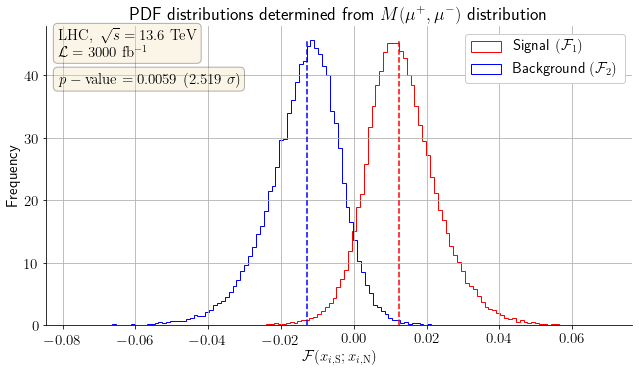

In [10]:
mpl.rcParams['text.usetex']=True 
mpl.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
plt.rcParams.update({'font.size': 15})
mpl.rcParams["legend.framealpha"] = 1.0
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.figsize"] = [10.5, 5.5]

f, ax = plt.subplots()

# If true, it will calculate the p-value based on a gaussian fit to the distributions
# If false, the p-value is calculated based on the median of the histograms
# The false option is more conservative and it is used in the paper. Although, the differences between 
# the options is not a lot.
# If true, the gaussian fit is also plotted, while for false only the histogram is plotted, as in the paper

Gauss_pval = False
Obs_label = '$M(\mu^+, \mu^-)$'
path_and_name = '/home/felipe/JoaoPino/1-LQsCollider_project/Plots/M_mumu_3000fb_1p5TeV.pdf'

if Gauss_pval == True:
    #Get bins for gaussian fit
    _, bins_S, _ = plt.hist(df['Log_prob_S'].to_numpy(), bins=100, density=1 , alpha=0.5)
    _, bins_B, _ = plt.hist(df['Log_prob_B'].to_numpy(), bins=100, density=1 , alpha=0.5)
    #Close so plots are not drawn
    plt.clf()
    
    #Signal plot
    mu_S, sigma_S = scipy.stats.norm.fit(df['Log_prob_S'].to_numpy())
    best_fit_line_S = scipy.stats.norm.pdf(bins_S, mu_S, sigma_S)
    df['Log_prob_S'].hist(bins=100, color='red', histtype = 'step', density=True)
    plt.plot(bins_S, best_fit_line_S, '-r')
    
    #Background plot
    mu_B, sigma_B = scipy.stats.norm.fit(df['Log_prob_B'].to_numpy())
    best_fit_line_B = scipy.stats.norm.pdf(bins_B, mu_B, sigma_B)
    df['Log_prob_B'].hist(bins=100, color='blue', histtype = 'step', density=True)
    plt.plot(bins_B, best_fit_line_B, '-b')
    
    #Calculate p-value and translate to sigmas
    p_value = 1 - norm.cdf(mu_S, mu_B, sigma_B)
    sigma = (mu_S - mu_B)/sigma_B
    
    #Plotting
    plt.legend([r'Signal $(\mathcal{F}_1)$', r'Background $(\mathcal{F}_2)$'], loc='upper right')
    plt.grid("on")
    plt.ylabel('Frequency')
    plt.xlabel(r'$\mathcal{F}(x_{i,\mathrm{S}}; x_{i,\mathrm{N}})$')
    plt.title(r'Gaussian fits determined from {} distribution'.format(Obs_label))
    plt.plot(np.ones(100)*mu_S, np.linspace(0,max(best_fit_line_S),100), '--r')
    plt.plot(np.ones(100)*mu_B, np.linspace(0,max(best_fit_line_B),100), '--b')

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    plt.text(0.02, 0.90, '$\mathrm{{LHC}},~\sqrt{{s}} = 13.6~\mathrm{{TeV}}$ \n $\mathcal{{L}}={l}~\mathrm{{fb^{{-1}}}}$'.format(l=int(lumi)), transform=plt.gca().transAxes, bbox=props)
    if p_value == 0.0:
        plt.text(0.02, 0.81, '$p-\mathrm{{value}} = 0.0000\dots~({0:.3f}~\sigma)$'.format(sigma), transform=plt.gca().transAxes, bbox=props)
    elif p_value != 0.0:
        plt.text(0.02, 0.81, '$p-\mathrm{{value}} = {a}~({b}~\sigma)$'.format(a=latex_float(p_value), b=np.round(sigma,3)), transform=plt.gca().transAxes, bbox=props)
    
    plt.savefig('{}'.format(path_and_name))
    plt.show()
    
if Gauss_pval == False:
    
    #Draw histograms
    hist_S = df['Log_prob_S'].hist(bins=100, color='red', histtype = 'step', density=True)
    hist_B = df['Log_prob_B'].hist(bins=100, color='blue', histtype = 'step', density=True)
    
    #Calculate sigmas based on median of the pdfs
    mu_S, mu_B = np.median(df['Log_prob_S'].to_numpy()), np.median(df['Log_prob_B'].to_numpy())
    sigma_B = np.std(df['Log_prob_B'].to_numpy())
    sigma = (mu_S - mu_B)/sigma_B
    p_value = scipy.stats.norm.sf(np.abs(sigma))
    
    #Plotting
    plt.legend([r'Signal $(\mathcal{F}_1)$', r'Background $(\mathcal{F}_2)$'], loc='upper right')
    plt.grid("on")
    plt.ylabel('Frequency')
    plt.xlabel(r'$\mathcal{F}(x_{i,\mathrm{S}}; x_{i,\mathrm{N}})$')
    plt.title(r'PDF distributions determined from {} distribution'.format(Obs_label))
    plt.plot(np.ones(100)*mu_S, np.linspace(0,hist_S.yaxis.get_data_interval()[-1],100), '--r')
    plt.plot(np.ones(100)*mu_B, np.linspace(0,hist_B.yaxis.get_data_interval()[-1],100), '--b')

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    plt.text(0.02, 0.90, '$\mathrm{{LHC}},~\sqrt{{s}} = 13.6~\mathrm{{TeV}}$ \n $\mathcal{{L}}={l}~\mathrm{{fb^{{-1}}}}$'.format(l=int(lumi)), transform=plt.gca().transAxes, bbox=props)
    if p_value == 0.0:
        plt.text(0.02, 0.81, '$p-\mathrm{{value}} = 0.0000\dots~({0:.3f}~\sigma)$'.format(sigma), transform=plt.gca().transAxes, bbox=props)
    elif p_value != 0.0:
        plt.text(0.02, 0.81, '$p-\mathrm{{value}} = {a}~({b}~\sigma)$'.format(a=latex_float(p_value), b=np.round(sigma,3)), transform=plt.gca().transAxes, bbox=props)
    
    plt.savefig('{}'.format(path_and_name))
    plt.show()

# Combined significance based on Stouffer's method

In [11]:
number_of_bins = 30
Observables = ['pt_l1', 'pt_l2', 'E_l1', 'E_l2', 'M_l1l2', 'pt_l1_CM', 'pt_l2_CM', 'E_l1_CM', 'E_l2_CM']
Masses = ['1p5TeV', '2p5TeV', '3p5TeV', '4p5TeV', '5p5TeV', '6p5TeV', '7p5TeV']
luminosity = [300., 3000.]
#The scale factor can be used to artificially tune the cross-section. This was used to determined the bounds for 
#Fig.6 of the paper. To use the correct xsec, the scale factor must be 1.0 !!!!
scale = 1.0 
#Number of pseudo experiments
N = 1_000
Gauss_pval = False

#Dict for significances
Significances_300 = {'Sigs_300_1p5TeV':[], 'Sigs_300_2p5TeV':[], 'Sigs_300_3p5TeV':[], 'Sigs_300_4p5TeV':[], 'Sigs_300_5p5TeV':[],
                     'Sigs_300_6p5TeV':[], 'Sigs_300_7p5TeV':[]}
Significances_3000 = {'Sigs_3000_1p5TeV':[], 'Sigs_3000_2p5TeV':[], 'Sigs_3000_3p5TeV':[], 'Sigs_3000_4p5TeV':[], 'Sigs_3000_5p5TeV':[],
                     'Sigs_3000_6p5TeV':[], 'Sigs_3000_7p5TeV':[]}

#path to data
path = "/home/felipe/JoaoPino/1-LQsCollider_project/Data_MadGraph/Full_data"

#Only need to read the Backgrounds once, so do it before loop
#However, this is only needed if you don't have the backgrounds already loaded in the kernel
#If you have, put background = False

#On the other hand, signals will be read in the loop, since I calculated for all benchmarks
background = False
if background:
    all_ttbar = glob.glob(path + "/ttbar_*.csv")
    all_WW = glob.glob(path + "/WW_*.csv")
    all_ZZ = glob.glob(path + "/ZZ_*.csv")
    all_ZW = glob.glob(path + "/ZW_*.csv")
    all_Zplusjets = glob.glob(path + "/Z_plus_jets_*.csv")

    #ttbar
    for filename in all_ttbar:
        df = pd.read_csv(filename, index_col=None, header=0)
        li_ttbar.append(df)

    ttbar = pd.concat(li_ttbar, axis=0, ignore_index=True)

    #WW
    for filename in all_WW:
        df = pd.read_csv(filename, index_col=None, header=0)
        li_WW.append(df)

    WW = pd.concat(li_WW, axis=0, ignore_index=True)

    #ZZ
    for filename in all_ZZ:
        df = pd.read_csv(filename, index_col=None, header=0)
        li_ZZ.append(df)

    ZZ = pd.concat(li_ZZ, axis=0, ignore_index=True)

    #ZW
    for filename in all_ZW:
        df = pd.read_csv(filename, index_col=None, header=0)
        li_ZW.append(df)

    ZW = pd.concat(li_ZW, axis=0, ignore_index=True)

    #Z plus jets
    for filename in all_Zplusjets:
        df = pd.read_csv(filename, index_col=None, header=0)
        li_Zplusjets.append(df)

    Z_plus_jets = pd.concat(li_Zplusjets, axis=0, ignore_index=True)

    Diboson = pd.concat([WW, ZZ, ZW],axis=0)

    #Reweight backgrounds to higher-order cross sections

    #Cross sections: Sums all values in collumn 'weight' in each data frame
    #Divided by the number of samples. I have batches of 10 samples, each with 100K events

    #ttbar
    ttbar_N3LO = 988.57
    ttbar_LO = 93.32
    ttbar_new_weight = (ttbar['xs_weight']*ttbar_N3LO)/ttbar_LO
    xsec_N3LO_ttbar = (ttbar_new_weight.sum()*1000)/10

    #Z plus jets
    Zjets_NNLO = 6.33*1e4
    Zjets_LO = 4128.0
    Zjets_new_weight = (Z_plus_jets['xs_weight']*Zjets_NNLO)/Zjets_LO
    xsec_NNLO_Zjets = (Zjets_new_weight.sum()*1000)/10

    #VV +jets. Cross sections for each individual process 
    #WW + jets
    WW_NLO = 124.31
    WW_LO = 77.22
    WW_new_weight = (WW['xs_weight']*WW_NLO)/WW_LO
    xsec_NNLO_WW = (WW_new_weight.sum()*1000)/10

    #WZ + jets
    ZW_NLO = 51.82
    ZW_LO = 0.9827
    ZW_new_weight = (ZW['xs_weight']*ZW_NLO)/ZW_LO
    xsec_NNLO_ZW = (ZW_new_weight.sum()*1000)/10

    #ZZ + jets
    ZZ_NLO = 17.72
    ZZ_LO = 0.03654
    ZZ_new_weight = (ZZ['xs_weight']*ZZ_NLO)/ZZ_LO
    xsec_NNLO_ZZ = (ZZ_new_weight.sum()*1000)/10

    ttbar['xs_weight'] = ttbar_new_weight
    Z_plus_jets['xs_weight'] = Zjets_new_weight
    WW['xs_weight'] = WW_new_weight
    ZW['xs_weight'] = ZW_new_weight
    ZZ['xs_weight'] = ZZ_new_weight

    Diboson = pd.concat([WW, ZZ, ZW],axis=0)

for mass in Masses:
    
    all_Signal = glob.glob(path + "/Correct_weights/LQ_Tchannel_{}.csv".format(mass))

    #Signal
    li_Signal = []
    for filename in all_Signal:
        df = pd.read_csv(filename, index_col=None, header=0)
        li_Signal.append(df)

    Signal = pd.concat(li_Signal, axis=0, ignore_index=True)

    
    for i in range(0, len(Observables)):
        Obs = Observables[i]
        for lumi in luminosity:
            print("Benchmark: {}. Running observable {} at {} fb^-1 ...".format(mass, Obs, lumi))
            #Weights for signal already in fb. Only need to multiply by 1000 on the backgrounds
            Get_events_background_l1 = Diboson[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Diboson[Obs].max()), bins=number_of_bins, weights=Diboson['xs_weight']*1000*lumi)))[0] + \
                                 Z_plus_jets[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Diboson[Obs].max()), bins=number_of_bins, weights=Z_plus_jets['xs_weight']*1000*lumi)))[0] + \
                                 ttbar[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Diboson[Obs].max()), bins=number_of_bins, weights=ttbar['xs_weight']*1000*lumi)))[0]
            Get_events_background_l1 = np.array([int(s) for s in Get_events_background_l1])

            Get_events_signal_l1 = Signal[Obs].pipe(lambda s: pd.Series(np.histogram(s, range=(Diboson[Obs].min(), Signal[Obs].max()), bins=number_of_bins, weights=scale*Signal['xs_weight']*lumi)))[0]
            Get_events_signal_l1 = np.array([int(s) for s in Get_events_signal_l1])

            Features = ['Log_prob_S', 'Log_prob_B']
            df = pd.DataFrame(columns=Features)

            #Arrays with the number of background events and the number of signal+background events
            Background = Get_events_background_l1
            Signal_plus_background = Get_events_background_l1 + Get_events_signal_l1

            #Up to which bins to use
            n_bins = np.where(Get_events_background_l1 == 0)[0][0]

            for idx in range(0, N):
                with warnings.catch_warnings():
                    warnings.filterwarnings('error')
                    try:

                        # ----- Signal -----
                        # Create new data that is poisson distributed based on the orignal simulated one
                        New_events_signal = np.array([ np.random.poisson(Signal_plus_background[i]) for i in range(0, n_bins) ])

                        # For the background, stay fixed
                        New_events_background = Background

                        # ----- Get probabilities ----- 
                        Get_probabilities_poisson_S = np.array([poisson.logpmf(k=New_events_signal[n], mu=New_events_background[n]) for n in range(0,n_bins)])    
                        Get_probabilities_poisson_B = np.array([poisson.logpmf(k=New_events_background[n], mu=New_events_signal[n]) for n in range(0,n_bins)])

                        Get_product_S = np.prod(Get_probabilities_poisson_S)
                        Get_product_B = np.prod(Get_probabilities_poisson_B)
                        Get_prob_S = np.log(Get_product_S/Get_product_B)

                        # ----- Background -----
                        # Create new data that is poisson distributed based on the orignal simulated one
                        New_events_background = np.array([ np.random.poisson(Background[i]) for i in range(0, n_bins) ])

                        # For the signal, stay fixed
                        New_events_signal = Signal_plus_background

                        # ----- Get probabilities ----- 
                        Get_probabilities_poisson_S = np.array([poisson.logpmf(k=New_events_background[n], mu=New_events_signal[n]) for n in range(0,n_bins)])    
                        Get_probabilities_poisson_B = np.array([poisson.logpmf(k=New_events_signal[n], mu=New_events_background[n]) for n in range(0,n_bins)])

                        Get_product_S = np.prod(Get_probabilities_poisson_S)
                        Get_product_B = np.prod(Get_probabilities_poisson_B)            
                        Get_prob_B = np.log(Get_product_S/Get_product_B)

                        Probs = [Get_prob_S, Get_prob_B]

                        # Save data data into a dataframe for further manipulation (df_S)
                        entry = pd.DataFrame([Probs], columns=Features)
                        df = df.append(entry)

                    except Warning as e:
                        continue

            if Gauss_pval == True:
                #Get bins for gaussian fit
                _, bins_S, _ = plt.hist(df['Log_prob_S'].to_numpy(), bins=100, density=1 , alpha=0.5)
                _, bins_B, _ = plt.hist(df['Log_prob_B'].to_numpy(), bins=100, density=1 , alpha=0.5)
                #Close so plots are not drawn
                plt.clf()

                #Signal
                mu_S, sigma_S = scipy.stats.norm.fit(df['Log_prob_S'].to_numpy())

                #Background
                mu_B, sigma_B = scipy.stats.norm.fit(df['Log_prob_B'].to_numpy())

                #Calculate p-value and translate to sigmas
                p_value = 1 - norm.cdf(mu_S, mu_B, sigma_B)
                sigma = (mu_S - mu_B)/sigma_B

            if Gauss_pval == False:

                #Draw histograms
                hist_S = df['Log_prob_S'].hist(bins=100, color='red', histtype = 'step', density=True)
                hist_B = df['Log_prob_B'].hist(bins=100, color='blue', histtype = 'step', density=True)
                #Close so plots are not drawn
                plt.clf()

                #Calculate sigmas based on median of the pdfs
                mu_S, mu_B = np.median(df['Log_prob_S'].to_numpy()), np.median(df['Log_prob_B'].to_numpy())
                sigma_B = np.std(df['Log_prob_B'].to_numpy())
                sigma = (mu_S - mu_B)/sigma_B
                p_value = scipy.stats.norm.sf(np.abs(sigma))

            if lumi == 300.:
                Significances_300['Sigs_300_{}'.format(mass)].append(np.abs(sigma))
            if lumi == 3000.:
                Significances_3000['Sigs_3000_{}'.format(mass)].append(np.abs(sigma))
                
    print("\n")
    print("=======================================")
    print("======== COMBINED SIGNIFICANCE ========")
    print("Mass benchmark {}".format(mass))
    print("For 300 fb^-1: σ = {}".format(sum(Significances_300['Sigs_300_{}'.format(mass)])/np.sqrt(len(Significances_300['Sigs_300_{}'.format(mass)]))))
    print("For 3000 fb^-1: σ = {}".format(sum(Significances_3000['Sigs_3000_{}'.format(mass)])/np.sqrt(len(Significances_3000['Sigs_3000_{}'.format(mass)]))))
    print("=======================================")
    print("")

print("Done! Thank you for choosing Valt-Tec !")


Benchmark: 1p5TeV. Running observable pt_l1 at 300.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable pt_l1 at 3000.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable pt_l2 at 300.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable pt_l2 at 3000.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable E_l1 at 300.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable E_l1 at 3000.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable E_l2 at 300.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable E_l2 at 3000.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable M_l1l2 at 300.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable M_l1l2 at 3000.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable pt_l1_CM at 300.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable pt_l1_CM at 3000.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable pt_l2_CM at 300.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable pt_l2_CM at 3000.0 fb^-1 ...
Benchmark: 1p5TeV. Running observable E_l1_CM at 300.0 fb^-1 ...
Benchmark: 1p5TeV. Running observabl

<Figure size 756x396 with 0 Axes>

# Construct latex code for Table 5 with the significances

In [12]:
from numpy import ma


In [13]:
def sig_figures(X, n):
    
    if isinstance(X, float):
        exp = np.floor(ma.log10(abs(X)))
        ans = np.round(X*10**-exp, n-1) * 10**exp
    else:    
        exp = np.floor(ma.log10(abs(X)).filled(0))
        ans = np.round(X*10**-exp, n-1) * 10**exp
    
    return ans

In [14]:
B1_col = '\\multirow{2}{*}{$1.5~\\mathrm{TeV}~(\\mathcal{B}1)$}' + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_1p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_1p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_1p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_1p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{(${f1}\\sigma$,\\, ${f2}\\sigma$)}}'.format(f1=sig_figures(sum(Significances_300['Sigs_300_{}'.format('1p5TeV')])/np.sqrt(len(Significances_300['Sigs_300_{}'.format('1p5TeV')])), 3),
                                                                            f2=sig_figures(sum(Significances_3000['Sigs_3000_{}'.format('1p5TeV')])/np.sqrt(len(Significances_3000['Sigs_3000_{}'.format('1p5TeV')])), 3)) + ' & ' + \
         '\\\\[5mm] \hhline{=============}'

B2_col = '\\multirow{2}{*}{$2.5~\\mathrm{TeV}~(\\mathcal{B}2)$}' + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_2p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_2p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_2p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_2p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{(${f1}\\sigma$,\\, ${f2}\\sigma$)}}'.format(f1=sig_figures(sum(Significances_300['Sigs_300_{}'.format('2p5TeV')])/np.sqrt(len(Significances_300['Sigs_300_{}'.format('2p5TeV')])), 3),
                                                                            f2=sig_figures(sum(Significances_3000['Sigs_3000_{}'.format('2p5TeV')])/np.sqrt(len(Significances_3000['Sigs_3000_{}'.format('2p5TeV')])), 3)) + ' & ' + \
         '\\\\[5mm] \hhline{=============}'

B3_col = '\\multirow{2}{*}{$3.5~\\mathrm{TeV}~(\\mathcal{B}3)$}' + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_3p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_3p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_3p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_3p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{(${f1}\\sigma$,\\, ${f2}\\sigma$)}}'.format(f1=sig_figures(sum(Significances_300['Sigs_300_{}'.format('3p5TeV')])/np.sqrt(len(Significances_300['Sigs_300_{}'.format('3p5TeV')])), 3),
                                                                            f2=sig_figures(sum(Significances_3000['Sigs_3000_{}'.format('3p5TeV')])/np.sqrt(len(Significances_3000['Sigs_3000_{}'.format('3p5TeV')])), 3)) + ' & ' + \
         '\\\\[5mm] \hhline{=============}'


B4_col = '\\multirow{2}{*}{$4.5~\\mathrm{TeV}~(\\mathcal{B}4)$}' + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_4p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_4p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_4p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_4p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{(${f1}\\sigma$,\\, ${f2}\\sigma$)}}'.format(f1=sig_figures(sum(Significances_300['Sigs_300_{}'.format('4p5TeV')])/np.sqrt(len(Significances_300['Sigs_300_{}'.format('4p5TeV')])), 3),
                                                                            f2=sig_figures(sum(Significances_3000['Sigs_3000_{}'.format('4p5TeV')])/np.sqrt(len(Significances_3000['Sigs_3000_{}'.format('4p5TeV')])), 3)) + ' & ' + \
         '\\\\[5mm] \hhline{=============}'

B5_col = '\\multirow{2}{*}{$5.5~\\mathrm{TeV}~(\\mathcal{B}5)$}' + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_5p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_5p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_5p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_5p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{(${f1}\\sigma$,\\, ${f2}\\sigma$)}}'.format(f1=sig_figures(sum(Significances_300['Sigs_300_{}'.format('5p5TeV')])/np.sqrt(len(Significances_300['Sigs_300_{}'.format('5p5TeV')])), 3),
                                                                            f2=sig_figures(sum(Significances_3000['Sigs_3000_{}'.format('5p5TeV')])/np.sqrt(len(Significances_3000['Sigs_3000_{}'.format('5p5TeV')])), 3)) + ' & ' + \
         '\\\\[5mm] \hhline{=============}'

B6_col = '\\multirow{2}{*}{$6.5~\\mathrm{TeV}~(\\mathcal{B}6)$}' + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_6p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_6p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_6p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_6p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{(${f1}\\sigma$,\\, ${f2}\\sigma$)}}'.format(f1=sig_figures(sum(Significances_300['Sigs_300_{}'.format('6p5TeV')])/np.sqrt(len(Significances_300['Sigs_300_{}'.format('6p5TeV')])), 3),
                                                                            f2=sig_figures(sum(Significances_3000['Sigs_3000_{}'.format('6p5TeV')])/np.sqrt(len(Significances_3000['Sigs_3000_{}'.format('6p5TeV')])), 3)) + ' & ' + \
         '\\\\[5mm] \hhline{=============}'

B7_col = '\\multirow{2}{*}{$7.5~\\mathrm{TeV}~(\\mathcal{B}7)$}' + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_7p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_7p5TeV'][4], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_300['Sigs_300_7p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{${f}\\sigma$}}'.format(f=sig_figures(Significances_3000['Sigs_3000_7p5TeV'][3], 3)) + ' & ' + \
         '\\multirow{{2}}{{*}}{{(${f1}\\sigma$,\\, ${f2}\\sigma$)}}'.format(f1=sig_figures(sum(Significances_300['Sigs_300_{}'.format('7p5TeV')])/np.sqrt(len(Significances_300['Sigs_300_{}'.format('7p5TeV')])), 3),
                                                                            f2=sig_figures(sum(Significances_3000['Sigs_3000_{}'.format('7p5TeV')])/np.sqrt(len(Significances_3000['Sigs_3000_{}'.format('7p5TeV')])), 3)) + ' & ' + \
         '\\\\[5mm] \hhline{=============}'


print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("{\\renewcommand{\\arraystretch}{0.9}%")
print("\\begin{table}[htb!]")
print("\\begin{center}")
print("\\captionsetup{justification=raggedright,singlelinecheck=true}")
print("\\resizebox{\columnwidth}{!}{%")
print("\\begin{tabular}{c|c|c|c|c|cccccccc}")
print("$M_{LQ}~(\\mathrm{GeV})$ & \\multicolumn{1}{c|}{\\makecell{$M(\\mu^+,\\mu^-)$ \\\\ $\\mathcal{L} = 300~\\mathrm{fb^{-1}}$}} & \\multicolumn{1}{c|}{\\makecell{$M(\\mu^+,\\mu^-)$ \\\\ $\\mathcal{L} = 3000~\\mathrm{fb^{-1}}$}} & \\multicolumn{1}{c|}{\\makecell{$E(\\mu^+)$ \\\\ $\\mathcal{L} = 300~\\mathrm{fb^{-1}}$}} & \\multicolumn{1}{c|}{\\makecell{$E(\\mu^+)$ \\\\ $\\mathcal{L} = 3000~\\mathrm{fb^{-1}}$}} & \\multicolumn{1}{c}{\\makecell{$\\mathrm{Combined}$ \\\\ $(300,3000)~\\mathrm{fb^{-1}}$}} \\\\[2mm] \\hline")
print(B1_col)
print(B2_col)
print(B3_col)
print(B4_col)
print(B5_col)
print(B6_col)
print(B7_col)
print("\\end{tabular}}")
print("\\caption{The statistical significance for each of the mass benchmarks mentioned in the text for $M(\\mu^+,\\mu^-)$ and $p_T(\\mu^+)$ distributions. In {\\redBU red} we indicate points that pass the $5\\sigma$ threshold for discovery. In the last column we show the combined significance, calculated using Stouffer's method, based on the distributions shown in Fig.~\\ref{fig:LQ_observables_2}. Points marked with ``$-$'' indicates that post-selection cross-section is not sufficient to produce a single event.}")
print("\\label{tab:significance_table}")
print("\\end{center}")
print("\\end{table}}")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
{\renewcommand{\arraystretch}{0.9}%
\begin{table}[htb!]
\begin{center}
\captionsetup{justification=raggedright,singlelinecheck=true}
\resizebox{\columnwidth}{!}{%
\begin{tabular}{c|c|c|c|c|cccccccc}
$M_{LQ}~(\mathrm{GeV})$ & \multicolumn{1}{c|}{\makecell{$M(\mu^+,\mu^-)$ \\ $\mathcal{L} = 300~\mathrm{fb^{-1}}$}} & \multicolumn{1}{c|}{\makecell{$M(\mu^+,\mu^-)$ \\ $\mathcal{L} = 3000~\mathrm{fb^{-1}}$}} & \multicolumn{1}{c|}{\makecell{$E(\mu^+)$ \\ $\mathcal{L} = 300~\mathrm{fb^{-1}}$}} & \multicolumn{1}{c|}{\makecell{$E(\mu^+)$ \\ $\mathcal{L} = 3000~\mathrm{fb^{-1}}$}} & \multicolumn{1}{c}{\makecell{$\mathrm{Combined}$ \\ $(300,3000)~\mathrm{fb^{-1}}$}} \\m] \hline
\multirow{2}{*}{$1.5~\mathrm{TeV}~(\mathcal{B}1)$} & \multirow{2}{*}{$0.731\sigma$} & \multirow{2}{*}{$2.5\sigma$} & \multirow{2}{*}{$0.9369999999999999\sigma$} & \multirow{2}{*}{$3.02\sigma$} & \multirow{2}{*}{($1.74\sigma$,\, $6.67\sigma$)} & \\m] \hhline{=============}